In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from decimal import Decimal, ROUND_HALF_UP

```console
# merge overlapping repeat elements
bedtools merge -i rm.bed -c 4,5,6 -o collapse > rm.collapsed.bed

# repeat elements in recently gained introns
bedtools intersect -a gained_introns.bed -b rm.collapsed.bed -wao | awk 'BEGIN{OFS="\t"} $NF>1 {print $1,$2,$3,$4,$5,$6,"repeats", $NF}' | datamash -s -g1,2,3,4,5,6,7 sum 8 > gained_introns.txt
bedtools intersect -a gained_introns.bed -b rm.collapsed.bed -wao | awk 'BEGIN{OFS="\t"} $NF==0 {print $1,$2,$3,$4,$5,$6,"no_repeats\t0"}' >> gained_introns.txt
bedtools intersect -a gained_introns.bed -b rm.collapsed.bed -wao | awk '$NF>1' | cut -f-6 | awk '!seen[$0]++' | wc -l
# 15
# Parsing output files from RepeatModeler
for i in *.rm.out; do \
  join -1 1 -2 4 -t$'\t' \
  <(grep ">" ${i%%.*}-families.fa | sed 's/#/\t/;s/>//' | awk -v taxid=${i%%.*} '{print taxid "|" $1 "\t" $2}' | sort -k1,1) \
  <(sort -k4,4 rm.bed)
done | awk 'BEGIN{OFS="\t"} {print $3,$4,$5,$2,$6,$7}' > rm_class.bed
bedtools sort -i rm_class.bed | bedtools merge -i stdin -c 4,5,6 -o collapse > rm_class.collapsed.bed
bedtools intersect -a gained_introns.bed -b rm_class.bed -wao | awk '$NF>1' > rm_class.wao
sed 's/|/\t/' rm_class.wao | cut -f1,11 | sort -u \
| while read i j; do \
grep "$i|" rm_class.wao | grep "$j" | awk 'BEGIN{OFS="\t"} {print $1,$2,$3,$10,$5,$6}' | bedtools merge -i stdin -s -c 4,6 -o distinct
done

# repeat elements in older introns
bedtools intersect -a present_introns.bed -b gained_introns.bed -wao | awk '$NF>0' | cut -f-6 | awk '!seen[$0]++' > gained_present_introns.bed
comm -13 <(sort gained_present_introns.bed) <(sort present_introns.bed | awk '{ sub("\r$", ""); print }') > old_introns.bed
bedtools intersect -a old_introns.bed -b rm.collapsed.bed -wao | awk 'BEGIN{OFS="\t"} $NF>1 {print $1,$2,$3,$4,$5,$6,"repeats", $NF}' | datamash -s -g1,2,3,4,5,6,7 sum 8 > old_introns.txt
bedtools intersect -a old_introns.bed -b rm.collapsed.bed -wao | awk 'BEGIN{OFS="\t"} $NF==0 {print $1,$2,$3,$4,$5,$6,"no_repeats\t0"}' >> old_introns.txt

# repeat elements in present exons
# uniq_exons.bed concatenated output files from extractTranscriptRegions
join -t$'\t' \
<(awk '!seen[$4]++ {print $4}' present_introns.bed | sort) \
<(sed 's/__.\+\t0/\t0/;s/|/\t/' uniq_exons.bed | awk 'BEGIN{OFS="\t"} {print $1 "|" $5, $1 "|" $2,$3,$4,$1 "|" $5,$6,$7}' | sort -k1,1) \
| cut -f2- > present_exons.bed
bedtools intersect -a present_exons.bed -b rm.collapsed.bed -wao | awk 'BEGIN{OFS="\t"} $NF>1 {print $1,$2,$3,$4,$5,$6,"repeats", $NF}' | datamash -s -g1,2,3,4,5,6,7 sum 8 > present_exons.txt
bedtools intersect -a present_exons.bed -b rm.collapsed.bed -wao | awk 'BEGIN{OFS="\t"} $NF==0 {print $1,$2,$3,$4,$5,$6,"no_repeats\t0"}' >> present_exons.txt

# repeat elements in intergenic regions
bedtools intersect -a intergenic.bed -b rm.collapsed.bed -wao | awk 'BEGIN{OFS="\t"} $NF>1 {print $1,$2,$3,"repeats", $NF}' | datamash -s -g1,2,3,4 sum 5 > intergenic.txt
bedtools intersect -a intergenic.bed -b rm.collapsed.bed -wao | awk 'BEGIN{OFS="\t"} $NF==0 {print $1,$2,$3,"no_repeats\t0"}' > intergenic.no_repeats.txt
join -t$'\t' \
<(sed 's/|/\t/' intergenic.txt | awk '!seen[$1]++ {print $1}' | sort -k1,1) \
<(awk '{print $1"\t"$0}' intergenic.no_repeats.txt | sed 's/|/\t/' | cut -f1,3- | sort -k1,1) | cut -f2- >> intergenic.txt
awk '!/Mt/ && !/Mito/' intergenic.txt > intergenic.txt2
mv intergenic.txt2 intergenic.txt
```

In [2]:
gi = pd.read_csv('gained_introns.txt', sep='\t', header=None)
gi.columns = ['chr','start','end','tid','score','strand','repeats','repeats_length']
gi['length'] = gi.end-gi.start
gi['rounded_length'] = gi.length.apply(lambda x: Decimal(x/10).to_integral_value(rounding=ROUND_HALF_UP)*10)
gi['class'] = 'gained'

oi = pd.read_csv('old_introns.txt', sep='\t', header=None)
oi.columns = ['chr','start','end','tid','score','strand','repeats','repeats_length']
oi['length'] = oi.end-oi.start
oi['rounded_length'] = oi.length.apply(lambda x: Decimal(x/10).to_integral_value(rounding=ROUND_HALF_UP)*10)
oi['class'] = 'present'

e = pd.read_csv('present_exons.txt', sep='\t', header=None)
e.columns = ['chr','start','end','tid','score','strand','repeats','repeats_length']
e['length'] = e.end-e.start
e['rounded_length'] = e.length.apply(lambda x: Decimal(x/10).to_integral_value(rounding=ROUND_HALF_UP)*10)
e['class'] = 'exons'

i = pd.read_csv('intergenic.txt', sep='\t', header=None)
i.columns = ['chr','start','end','repeats','repeats_length']
i['length'] = i.end-i.start
i['rounded_length'] = i.length.apply(lambda x: Decimal(x/10).to_integral_value(rounding=ROUND_HALF_UP)*10)
i['class'] = 'intergenic'

In [3]:
d = pd.concat([gi, oi, e])
d = d[['chr','start','end','repeats','repeats_length','length','rounded_length','class']]
d = pd.concat([i, d[['chr','start','end','repeats','repeats_length',
                     'length','rounded_length','class']]])

[None]

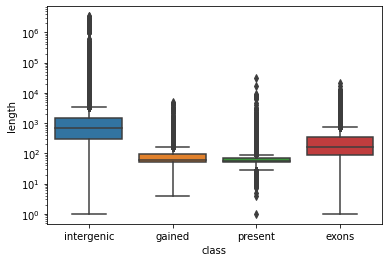

In [4]:
g = sns.boxplot(x='class', y='length', data=d)
g.set(yscale="log")

In [5]:
l = pd.DataFrame(gi['rounded_length'].value_counts(normalize=True)).reset_index()
l.columns = ['rounded_length','weight']
df = pd.merge(d, l, on='rounded_length')

gi = df[df['class']=='gained']
oi = df[df['class']=='present']
e = df[df['class']=='exons']
i = df[df['class']=='intergenic']

In [6]:
gi.shape,oi.shape,e.shape,i.shape

((3227, 9), (223723, 9), (646042, 9), (1640077, 9))

In [7]:
ls = []
for j in list(range(1,1001)):
    gis = gi.sample(n=1000, weights=gi['weight'], random_state=j)
    ois = oi.sample(n=1000, weights=oi['weight'], random_state=j)
    es = e.sample(n=1000, weights=e['weight'], random_state=j)
    igs = i.sample(n=1000, weights=i['weight'], random_state=j)
    d = pd.concat([gis,ois,es,igs])
    d = pd.DataFrame(d.groupby('class')[['length','repeats_length']].sum()).reset_index()
    d['bootstrap'] = j
    ls.append(d)
    
d = pd.concat(ls).reset_index(drop=True)
d['percent_repeats'] = d.repeats_length / d.length * 100
d.to_pickle('gained_introns_bs.pkl')

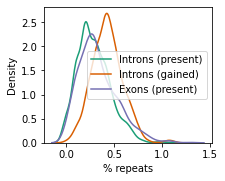

In [8]:
plt.figure(figsize=(3,2.5))
sns.kdeplot(x=d[d['class']=='present'].percent_repeats, color='#1b9e77',
            label='Introns (present)')
sns.kdeplot(x=d[d['class']=='gained'].percent_repeats, color='#d95f02', 
            label='Introns (gained)')
sns.kdeplot(x=d[d['class']=='exons'].percent_repeats, color='#7570b3', 
            label='Exons (present)')
plt.xlabel('% repeats')
plt.ylabel('Density')
plt.legend()
plt.savefig('gained_introns_bs.pdf')

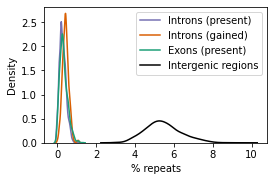

In [9]:
plt.figure(figsize=(4,2.5))
sns.kdeplot(x=d[d['class']=='present'].percent_repeats, color='#7570b3', 
            label='Introns (present)')
sns.kdeplot(x=d[d['class']=='gained'].percent_repeats, color='#d95f02', 
            label='Introns (gained)')
sns.kdeplot(x=d[d['class']=='exons'].percent_repeats, color='#1b9e77', 
            label='Exons (present)')
sns.kdeplot(x=d[d['class']=='intergenic'].percent_repeats, color='#000000', 
            label='Intergenic regions')
plt.xlabel('% repeats')
plt.ylabel('Density')
plt.legend()
plt.savefig('gained_introns_bs_int.pdf')

In [10]:
stats.ks_2samp(d[d['class']=='present'].percent_repeats, 
               d[d['class']=='gained'].percent_repeats)

KstestResult(statistic=0.379, pvalue=2.32104283415554e-64)

In [11]:
stats.ks_2samp(d[d['class']=='exons'].percent_repeats, 
               d[d['class']=='gained'].percent_repeats)

KstestResult(statistic=0.31, pvalue=7.79277593568231e-43)

In [12]:
stats.ks_2samp(d[d['class']=='present'].percent_repeats, 
               d[d['class']=='exons'].percent_repeats)

KstestResult(statistic=0.116, pvalue=2.798513019401821e-06)

In [13]:
d.groupby('class')[['percent_repeats']].median()

,percent_repeats
class,
exons,0.294355
gained,0.418727
intergenic,5.374274
present,0.277018


In [14]:
0.418727/0.277018

1.5115515959251746